In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt




# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv
/kaggle/input/dataiku/SRD.csv
/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv


In [2]:
df1 = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
print(df1.head())
test_essay_file = "/kaggle/input/llm-detect-ai-generated-text/test_essays.csv"
df_test_essay = pd.read_csv(test_essay_file)
train_essay_ex_file = "/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv"
df_train_essay_ex = pd.read_csv(train_essay_ex_file)
df_train_essay_ex.head()



         id  prompt_id                                               text  \
0  0059830c          0  Cars. Cars have been around since they became ...   
1  005db917          0  Transportation is a large necessity in most co...   
2  008f63e3          0  "America's love affair with it's vehicles seem...   
3  00940276          0  How often do you ride in a car? Do you drive a...   
4  00c39458          0  Cars are a wonderful thing. They are perhaps o...   

   generated  
0          0  
1          0  
2          0  
3          0  
4          0  


,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


In [3]:
X_text = np.array(df1['text'])
y = np.array(df1['generated'])
df_train_essay_ex.rename(columns = {"label":"generated"}, inplace=True)
df_train = pd.concat([df_train_essay_ex[["text", "generated"]],
                                   df1[["text", "generated"]]])


In [4]:
# Split the data into training and testing sets
x, y = df_train['text'], df_train['generated']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=2529)



In [5]:
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Convert text data to TF-IDF features for training set
X_train_tfidf = tfidf_vectorizer.fit_transform(x_train)

# Convert text data to TF-IDF features for testing set
X_test_tfidf = tfidf_vectorizer.transform(x_test)

In [6]:
# Initialize Logistic Regression model
logistic_regression_model = LogisticRegression()

# Train the model on the training set
logistic_regression_model.fit(X_train_tfidf, y_train)

# Make predictions on the testing set
y_pred = logistic_regression_model.predict(X_test_tfidf)




In [7]:
# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.991350727980395
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      8680
           1       1.00      0.98      0.99      5194

    accuracy                           0.99     13874
   macro avg       0.99      0.99      0.99     13874
weighted avg       0.99      0.99      0.99     13874



In [8]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[8666,   14],
       [ 106, 5088]])

In [9]:
pd.crosstab(y_test,y_pred)

col_0,0,1
generated,,
0,8666,14
1,106,5088


In [10]:
feature_coefficients = logistic_regression_model.coef_[0]

# Get feature names 
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame to display feature names and their coefficients
feature_coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': feature_coefficients})

# Sort the DataFrame by coefficients in descending order
feature_coefficients_df = feature_coefficients_df.sort_values(by='Coefficient', ascending=False)

# Print the feature coefficients DataFrame
print("Feature Coefficients:\n", feature_coefficients_df[::-1])


Feature Coefficients:
           Feature  Coefficient
6647      because    -8.702247
57825         the    -6.564556
62243        very    -5.643606
35716        many    -4.768917
64270       would    -4.580070
...           ...          ...
12638  conclusion     4.708634
44261   potential     4.832634
3657          and     5.393730
30053   important     5.975801
46793          re     6.826959

[64832 rows x 2 columns]


ROC AUC Score: 0.99


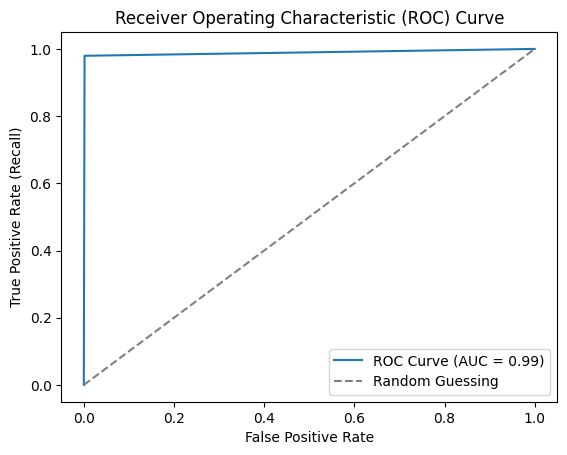

In [11]:

# Calculate ROC AUC score
auc_score = roc_auc_score(y_test, y_pred)
print(f'ROC AUC Score: {auc_score:.2f}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [12]:
t=df_test_essay['text']
tfidf_test1 = tfidf_vectorizer.transform(t)
y_pred = logistic_regression_model.predict_proba(tfidf_test1)[:, 1]
#[:,1] prints only probability for predicted class
y_pred

array([0.9241888, 0.9262279, 0.9262279])

In [13]:
prob_pred = logistic_regression_model.predict_proba(X_test_tfidf)[:, 1]
print("generated:",prob_pred[:5])

generated: [0.00289263 0.00543387 0.97647596 0.08880471 0.35385631]


In [14]:
submission_data = {'id': df_test_essay['id'], 'generated': y_pred}
submission = pd.DataFrame(submission_data)

# Save the DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)
submission



,id,generated
0,0000aaaa,0.924189
1,1111bbbb,0.926228
2,2222cccc,0.926228
